# **Twitter** **Sentiment** **Analysis**

# Google Colab Link: - https://colab.research.google.com/drive/1WftQX16STUbiQRGBYQ6US48UrzoVzSDx?usp=sharing

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install tweepy

In [ ]:
!pip install wordcloud

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install gensim

In [ ]:
!pip install pyLDAvis.gensim

In [7]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.naive_bayes import BernoulliNB 
from sklearn.svm import SVC
import gensim
from gensim import corpora, models
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
from collections import Counter
from nltk import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# **Extraction** **Of** **Tweets**



Tweepy API was used to extract the relevant tweets to perform the sentiment analysis. 2 API keys were generated which was then used to extract 1500 tweets under the tag "Expo2020" using the first API key and an other 1500 tweets under the tag "Expo2020dubai" making it a total of 3000 tweets to form our dataset.
The parameters of the tweets retrieval was such that the tweets were only english and the retweets were excluded.

In [8]:
#API keys to access Twitter API
consumerKey = "DmBe5ODGyEgyiEvImmTjeCGum"
consumerSecret = "QSsnT4dx9pQHX70l2llX34BlraQCgbavQVw5g9UQxOCrAI17vH"
accessToken = "876135085594083328-o8cHe8o7RwQzacjLtnIKgyG8GIzLW19"
accessTokenSecret = "rorFvRdljoCbsyQi8bnFicD1S5hOpFIbOG3pjWjuiycmO"

consumerKey2 = "PWSN3Yv3AztljDSU6kH0lpc4G"
consumerSecret2 = "HLBZ2MzZ9pULpsL5eo82QQ68M1A1pTY2GMxFDqxgChQGWTcngr"
accessToken2 = "1485153622208008197-ImHH2sNBgkIQLNB3di7WuTYsoIT3W5"
accessTokenSecret2 = "xU4uK5G1rutfkubWhmGRXtOFMddhiQCm7RruKqM2TnDih"

In [9]:
# Authenticating the API with the given keys
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

auth2 = tweepy.OAuthHandler(consumerKey2, consumerSecret2)
auth2.set_access_token(accessToken2, accessTokenSecret2)
api2 = tweepy.API(auth2,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [10]:
tag = "Expo2020"
NoOfTweets = 1500
tag2 = "Expo2020dubai"

In [11]:
# Retrieving real time tweets under the tag Expo2020 and Expo2020dubai
exptweets = tweepy.Cursor(api.search,lang="en", q=tag+"-filter:retweets").items(NoOfTweets)
exptweets
exptweets2 = tweepy.Cursor(api2.search,lang="en", q=tag2+"-filter:retweets").items(NoOfTweets)
exptweets2

In [12]:
# Appending all the tweets retrieved into a list
text = []
for tweet in exptweets:
    text.append(tweet.text)

for tweet2 in exptweets2:
    text.append(tweet2.text)

    

In [ ]:
len(text)
# creating a dictionary of the tweets which can be later on made into a dataframe
data = {
    "tweets": text
}
data

In [14]:
df = pd.DataFrame(data)
df = df.drop_duplicates()

# **Cleaning** **Tweets**

The tweets retrieved were the cleaned by removing hashtags, tagged users, links and punctuations

In [15]:
# Function to clean the tweets in the dataframe
def clean (tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+','',tweet) #Remove tags of username and etc, starting with @
    tweet = re.sub(r'#','',tweet) # Removing #'s from the tweets
    tweet = re.sub(r'https?:/\/\S+','',tweet, flags=re.MULTILINE) # removing links from the tweets
    tweet = tweet.replace('\n', '') # removing unwanted \n escape sequences from the tweets
    tweet = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', tweet) # removing punctuations from the tweets
    return tweet

In [16]:
df['tweets'] = df['tweets'].apply(clean)
df

,tweets
0,What will you find at the CPS centre at Borro...
1,Visits to Expo2020 Dubai exceed 19 Million Exp...
2,Journalist Najib El Khash shared how distribut...
3,We have been joined by Carol Bouwer at our pav...
4,The Road to Fulfilment tells the stories of th...
...,...
2995,Dear AirlineUkrainian people urge you to st...
2996,After the Russian invasion of Ukraine thous...
2997,Why dont you join the world and stop financ...
2998,Stop cooperating with the aggressor As long...


# **TextBlob** **Analysis**

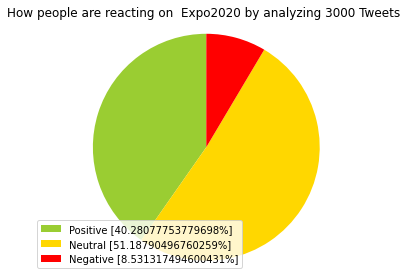

In [17]:
pos = 0
neg = 0
neu = 0
pol = 0
polarity = []
tanalysis = []
count = 0

# Text blob evaluation by taking one tweet at a time from the dataframe and computing the polarity score
for t in df['tweets']:
    analysis = TextBlob(t) 
    
    pol += analysis.sentiment.polarity
    polarity.append(analysis.sentiment.polarity)
    count += 1
   
    if(analysis.sentiment.polarity == 0):
        neu += 1
        tanalysis.append("Neutral")
    elif(analysis.sentiment.polarity < 0.00):
        neg += 1
        tanalysis.append("Negative")

    elif(analysis.sentiment.polarity > 0.00):
        pos += 1
        tanalysis.append("Positve")

# Function to calculate the percentage
def perc(part,whole):
    return 100 * float(part)/float(whole)


pos = perc(pos, count)
neg = perc(neg, count)
neu = perc(neu, count)
pol = perc(pol, count)

#Creating pie chart from the sentiment percentages retrieved from the text blob analysis
labels = ['Positive ['+str(pos)+'%]', 
          'Neutral ['+str(neu)+'%]', 
          'Negative ['+str(neg)+'%]']
sizes = [pos, neu, neg]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title('How people are reacting on  '
          +tag+' by analyzing '
          +str(NoOfTweets*2)+' Tweets ')
plt.axis('equal')
plt.tight_layout()
plt.show()

An initial analysis was performed using text blob on the tweets dataframe, computing the polarity of the tweets and got the following results as given in the pie chart: -
*   40.2% of the tweets are returned as Positive
*   51.1% of the tweets are returned as Neutral
*   8.5% of the tweets are returned as Negative



# **VADER** **Analysis**

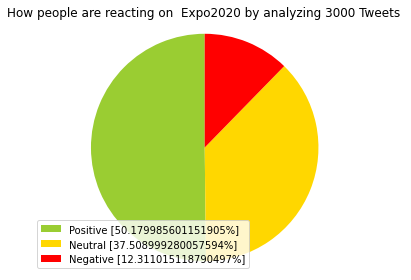

In [18]:
analyser = SentimentIntensityAnalyzer()

# VADER evaluation on the tweets dataframe and computing the polarity scores
def negvad (t):
    return analyser.polarity_scores(t)['neg']
def posvad (t):
    return analyser.polarity_scores(t)['pos']
def neuvad (t):
    return analyser.polarity_scores(t)['neu']
def compvad (t):
    return analyser.polarity_scores(t)['compound']

vpos = 0
vneg = 0
vneu = 0

# Function to lable the tweet in the dataframe based on the compound score evaluated
def analysertext(t):
    if(analyser.polarity_scores(t)['compound'] == 0):
        return 'Neutral'
    elif(analyser.polarity_scores(t)['compound'] < 0.00):
        return 'Negative'
    elif(analyser.polarity_scores(t)['compound'] > 0.00):
        return 'Positive'
    
    
# creating a dictionary of the tweets which can be later on made into a dataframe
data3 = {
    "tweets": text
}

# Performing the analysis and labeling for the dataframe
df3 = pd.DataFrame(data3)
df3 = df3.drop_duplicates()
df3['tweets'] = df3['tweets'].apply(clean)
df3['negative'] = df3['tweets'].apply(negvad)
df3['positive'] = df3['tweets'].apply(posvad)
df3['neutral'] = df3['tweets'].apply(neuvad)
df3['compound'] = df3['tweets'].apply(compvad)
df3['analysis'] = df3['tweets'].apply(analysertext)

# To get the count of each sentiment
for t in df3['tweets']:
    if(analyser.polarity_scores(t)['compound'] == 0):
        vneu += 1
    elif(analyser.polarity_scores(t)['compound'] < 0.00):
        vneg += 1
    elif(analyser.polarity_scores(t)['compound'] > 0.00):
        vpos += 1

vpos = perc(vpos, count)
vneg = perc(vneg, count)
vneu = perc(vneu, count)

labels = ['Positive ['+str(vpos)+'%]', 
          'Neutral ['+str(vneu)+'%]', 
          'Negative ['+str(vneg)+'%]']

#Creating pie chart from the sentiment percentages retrieved from the VADER analysis
sizes = [vpos, vneu, vneg]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title('How people are reacting on  '
          +tag+' by analyzing '
          +str(NoOfTweets*2)+' Tweets ')
plt.axis('equal')
plt.tight_layout()
plt.show()

Further ahead VADER Analysis was performed onto the tweets dataframe and got the following results as given in the pie chart: -
*   50.1% of the tweets are returned as Positive
*   37.5% of the tweets are returned as Neutral
*   12.3% of the tweets are returned as Negative

The VADER Analysis gives a compound score which is the polarity which is computed using the positive score, negative score and the neutral score of one tweet.

Using the compound score computed by VADER, we labled the tweets accordingly into the dataset. The labeling conditions were as follow: -

*   If the compund score computer is greater than zero then the tweet is labled as Positive
*  If the compund score computer is equal to zero then the tweet is labled as Neutral
* If the compund score computer is lesser than zero then the tweet is labled as Negative

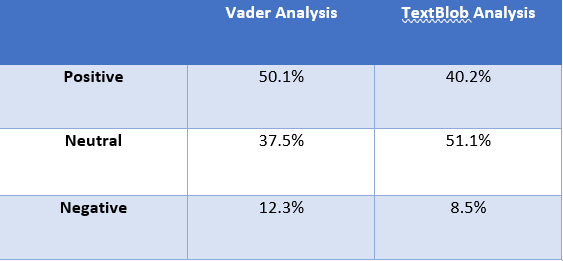


Vader Analysis was decided to use for labeling of tweets as it gives a better insight towards the negative tweets than that what text blob which was observed from the above analysis and this be useful to have a better idea of how people exactly feel about expo 2020 and based on the negative inputs have an idea on how to go foward to improve peoples experience.
We could also lable the tweets manually but since the dataset contains about 3000 tweets we did not choose the manual hand tag method.


# **Tweet** **Text** **Pre**-**Processing** (Tokenization, removing stop words, Stemming, Lemmatization)

In [19]:
# Pre-processing of the tweets in the dataset
def processing(t):
    
    #tokenization of tweets
    tokens = []
    tokens = word_tokenize(t)
    
    #removal of stop words
    
    stpwrds = set(stopwords.words('english'))
    filtert = []
    filtert = [i for i in tokens if i not in stpwrds]
    
    #Stemming of tweets
    
    stem = PorterStemmer()
    stemt = []
    stemt = [stem.stem(i) for i in filtert]
    
    #Lemmatization of tweets
    
    lem = WordNetLemmatizer()
    lemt = [lem.lemmatize(i,'v') for i in stemt]
    
    #processed tweet
    
    processedt = ' '.join(lemt)
    
    return processedt

In [20]:
df3['tweets'] = df3['tweets'].apply(processing)
df3

,tweets,negative,positive,neutral,compound,analysis
0,what find cp centr borrow tri latest camera le...,0.000,0.000,1.000,0.0000,Neutral
1,visit expo2020 dubai exceed 19 million expo202...,0.000,0.000,1.000,0.0000,Neutral
2,journalist najib El khash share distribut book...,0.000,0.267,0.733,0.7351,Positive
3,We join carol bouwer pavilion today kick 2 day...,0.000,0.000,1.000,0.0000,Neutral
4,the road fulfil tell stori three emot invest i...,0.000,0.000,1.000,0.0000,Neutral
...,...,...,...,...,...,...
2995,dear airlineukrainian peopl urg stop cooper ag...,0.256,0.167,0.577,-0.1027,Negative
2996,after russian invas ukrain thousand hous destr...,0.211,0.000,0.789,-0.4939,Negative
2997,whi dont join world stop financ war stop toler...,0.598,0.000,0.402,-0.9311,Negative
2998,stop cooper aggressor As long cooper russia pay…,0.250,0.000,0.750,-0.4588,Negative


All the tweets in the dataset needs to be pre-processed before going foward with training our models to get the dataset into a consistent format, this is done using the NLTK library. The pre-processes that are being done are as follows: - 

*   The tweets are converted into a list of tokens
*   All the stop-words that the tweets contain are removed
*   Stemming of the words
*   Lemmatization of the words




# **TD**-**IF** **Vectorizer**

To train our model we need to make the textual data into numerical data by vectorization. For this we used the TD-IF vectorizer approach to convert the tweets into its corresponding numeric data. The analysis column that have the values "Positive", "Neutral", "Negative" was converted to 1, 0, -1 respectively.

In [21]:
# Function that conversts text into vector form using the td-if vectorizer and passing n as parameter to make the words into n-grams
def tfidf(t,n):
    vect = TfidfVectorizer(ngram_range = (n,n),sublinear_tf= True)
    vectFit = vect.fit_transform(t)
    return vectFit
tweetList = np.array(df['tweets'].ravel())

# Tweets vector for unigram
X = tfidf(tweetList,1)
X.shape

(2778, 6680)

In [22]:
# Converting the sentiment analysis from negative, positive and neutral to -1, 1 and 0 respectively
df3['analysis'] = df3.analysis.map({'Negative': -1,
                                                'Positive': 1,
                                                'Neutral': 0})
df3

,tweets,negative,positive,neutral,compound,analysis
0,what find cp centr borrow tri latest camera le...,0.000,0.000,1.000,0.0000,0
1,visit expo2020 dubai exceed 19 million expo202...,0.000,0.000,1.000,0.0000,0
2,journalist najib El khash share distribut book...,0.000,0.267,0.733,0.7351,1
3,We join carol bouwer pavilion today kick 2 day...,0.000,0.000,1.000,0.0000,0
4,the road fulfil tell stori three emot invest i...,0.000,0.000,1.000,0.0000,0
...,...,...,...,...,...,...
2995,dear airlineukrainian peopl urg stop cooper ag...,0.256,0.167,0.577,-0.1027,-1
2996,after russian invas ukrain thousand hous destr...,0.211,0.000,0.789,-0.4939,-1
2997,whi dont join world stop financ war stop toler...,0.598,0.000,0.402,-0.9311,-1
2998,stop cooper aggressor As long cooper russia pay…,0.250,0.000,0.750,-0.4588,-1


In [23]:
Y = df3['analysis']
Y

0       0
1       0
2       1
3       0
4       0
       ..
2995   -1
2996   -1
2997   -1
2998   -1
2999    0
Name: analysis, Length: 2778, dtype: int64

# **Logistic** **Regression** **Unigram** 

In [ ]:
#Splitting that data in 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Logistic Regression Model for Bigram
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(accuracy_score(y_test,y_pred))

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.48      0.65        73
           0       0.71      0.67      0.69       200
           1       0.72      0.84      0.78       283

    accuracy                           0.73       556
   macro avg       0.81      0.66      0.70       556
weighted avg       0.75      0.73      0.73       556



# **Naive** **Bayes** **Unigram**

In [26]:
#Naive Bayes Model for Unigram
BN = BernoulliNB()
BN.fit(X_train, y_train)
y_pred2 = BN.predict(X_test)
print(accuracy_score(y_test,y_pred2))

0.7176258992805755


In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.48      0.65        73
           0       0.71      0.67      0.69       200
           1       0.72      0.84      0.78       283

    accuracy                           0.73       556
   macro avg       0.81      0.66      0.70       556
weighted avg       0.75      0.73      0.73       556



# **Support** **Vector** **Machine** **Unigram**

In [28]:
#Support Vector Machine Model for Unigram
SVM = SVC(kernel='linear')
SVM.fit(X_train, y_train)
Sy_pred = SVM.predict(X_test)
print(accuracy_score(y_test,Sy_pred))

0.7535971223021583


In [29]:
print(classification_report(y_test,Sy_pred))

              precision    recall  f1-score   support

          -1       0.92      0.49      0.64        73
           0       0.70      0.75      0.73       200
           1       0.77      0.82      0.79       283

    accuracy                           0.75       556
   macro avg       0.80      0.69      0.72       556
weighted avg       0.76      0.75      0.75       556



In [30]:
# Tweets vector for bigram
X2 = tfidf(tweetList,2)
X2.shape

(2778, 19856)

# **Logistic** **Regression** **Bigram** 

In [ ]:
#Splitting that data in 80% training set and 20% testing set
X2_train, X2_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=0)

#Logistic Regression Model for Bigram
LR2 = LogisticRegression()
LR2.fit(X2_train, y_train)
y_pred3 = LR2.predict(X2_test)
print(accuracy_score(y_test,y_pred3))

In [32]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

          -1       1.00      0.38      0.55        73
           0       0.81      0.32      0.45       200
           1       0.60      0.96      0.74       283

    accuracy                           0.65       556
   macro avg       0.80      0.55      0.58       556
weighted avg       0.73      0.65      0.61       556



# **Naive** **Bayes** **Bigram**

In [33]:
#Naive Bayes Model for Bigram
BN2 = BernoulliNB()
BN2.fit(X2_train, y_train)
y_pred4 = BN2.predict(X2_test)
print(accuracy_score(y_test,y_pred4))

0.564748201438849


In [34]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        73
           0       0.62      0.31      0.41       200
           1       0.55      0.89      0.68       283

    accuracy                           0.56       556
   macro avg       0.39      0.40      0.37       556
weighted avg       0.50      0.56      0.50       556



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Support** **Vector** **Machine** **Bigram**

In [35]:
#Support Vector Machine Model for Bigram
SVM2 = SVC(kernel='linear')
SVM2.fit(X2_train, y_train)
Sy_pred2 = SVM2.predict(X2_test)
print(accuracy_score(y_test,Sy_pred2))

0.6618705035971223


In [36]:
print(classification_report(y_test,Sy_pred2))

              precision    recall  f1-score   support

          -1       1.00      0.44      0.61        73
           0       0.72      0.39      0.51       200
           1       0.62      0.91      0.74       283

    accuracy                           0.66       556
   macro avg       0.78      0.58      0.62       556
weighted avg       0.71      0.66      0.64       556



In [37]:
# Tweets vector for trigram
X3 = tfidf(tweetList,3)
X3.shape

(2778, 23745)

# **Logistic** **Regression** **Tigram** 

In [ ]:
#Splitting that data in 80% training set and 20% testing set
X3_train, X3_test, y_train, y_test = train_test_split(X3, Y, test_size=0.2, random_state=0)

#Logistic Regression Model for Bigram
LR3 = LogisticRegression()
LR3.fit(X3_train, y_train)
y_pred5 = LR3.predict(X3_test)

In [39]:
print(classification_report(y_test,y_pred5))

              precision    recall  f1-score   support

          -1       1.00      0.37      0.54        73
           0       0.95      0.21      0.34       200
           1       0.58      0.99      0.73       283

    accuracy                           0.63       556
   macro avg       0.84      0.52      0.54       556
weighted avg       0.77      0.63      0.57       556



# **Naive** **Bayes** **Trigram**

In [40]:
#Naive Bayes Model for Trigram
BN3 = BernoulliNB()
BN3.fit(X3_train, y_train)
y_pred6 = BN3.predict(X3_test)
print(accuracy_score(y_test,y_pred6))

0.5431654676258992


In [41]:
print(classification_report(y_test,y_pred6))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        73
           0       0.66      0.19      0.29       200
           1       0.53      0.93      0.68       283

    accuracy                           0.54       556
   macro avg       0.40      0.37      0.32       556
weighted avg       0.51      0.54      0.45       556



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Support** **Vector** **Machine** **Trigram**

In [42]:
#Support Vector Machine Model for Trigram
SVM3 = SVC(kernel='linear')
SVM3.fit(X3_train, y_train)
Sy_pred3 = SVM3.predict(X3_test)
print(accuracy_score(y_test,Sy_pred3))

0.6384892086330936


In [43]:
print(classification_report(y_test,Sy_pred3))

              precision    recall  f1-score   support

          -1       1.00      0.41      0.58        73
           0       0.92      0.23      0.37       200
           1       0.59      0.99      0.74       283

    accuracy                           0.64       556
   macro avg       0.84      0.54      0.56       556
weighted avg       0.76      0.64      0.58       556



We trained with our dataset with 3 classifiers which are Logistic Regression, Naive Bayes and Support Vector Machine. The precision and recall scores of these classifers are as follows : -
1.  Logistic Regression
    *   Precision: - 0.75
    *   Recall: - 0.73
2.  Naive Bayes
    *   Precision: - 0.75
    *   Recall: - 0.73
3.  Support Vector Machine
    *   Precision: - 0.76
    *   Recall: - 0.75

Among the three classifires the SVM classifire gave the better scores than the rest which we conclude that SVM would be prefered to use for twitter sentiment analysis for this dataset. 

We further ahead did classification experiments with bigrams and trigrams on the three classifires and these gave the scores as below: -

**Bigram** **Scores**
1.  Logistic Regression
    *   Precision: - 0.73
    *   Recall: - 0.65
2.  Naive Bayes
    *   Precision: - 0.50
    *   Recall: - 0.56
3.  Support Vector Machine
    *   Precision: - 0.71
    *   Recall: - 0.66

**Trigram** **Scores**
1.  Logistic Regression
    *   Precision: - 0.77
    *   Recall: - 0.63
2.  Naive Bayes
    *   Precision: - 0.51
    *   Recall: - 0.54
3.  Support Vector Machine
    *   Precision: - 0.76
    *   Recall: - 0.64

From the following scores, we can conclude that when the number of grams of words are increased the precision and recall score in general starts to decrease slightly. Therefore, according to this observation it is better to use SVM classification with unigram words which gave a precision of 0.75 and recall of 0.73.



In [44]:
# Getting the list of words that are labled positive
posct = df3[df3['analysis'] == 1]['tweets']
posctw = [word for words in posct for word in words.split()]
posctw[:10]

['journalist',
 'najib',
 'El',
 'khash',
 'share',
 'distribut',
 'book',
 'dubai',
 '’',
 'success']

In [45]:
# Getting the list of words that are labled negative
negct = df3[df3['analysis'] == -1]['tweets']
negctw = [word for words in negct for word in words.split()]
negctw[:10]

['profession',
 'pro',
 'servic',
 'start',
 '400',
 'aed✓',
 'full',
 'benifits✓',
 'quick',
 'process✓']

In [46]:
# Getting the list of words that are labled neutral
neuct = df3[df3['analysis'] == 0]['tweets']
neuctw = [word for words in neuct for word in words.split()]
neuctw[:10]

['what',
 'find',
 'cp',
 'centr',
 'borrow',
 'tri',
 'latest',
 'camera',
 'lens',
 'get']

# **Word** **Cloud** **For** **Negative** **Tweets**

(-0.5, 999.5, 499.5, -0.5)

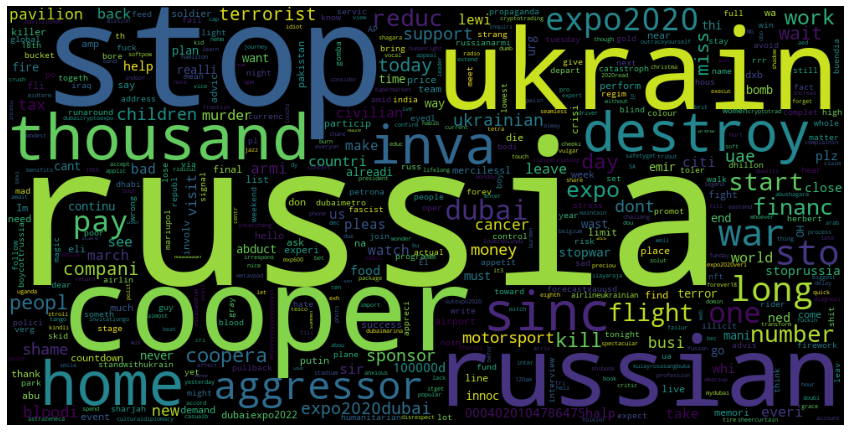

In [47]:
# Plotting the word cloud of negative words using the list of labled negative
plt.figure(figsize = (15,15))
wcneg = WordCloud(max_words = 500 , width = 1000 , height = 500,
               collocations=False).generate(" ".join(negctw))
plt.imshow(wcneg)
plt.axis('off')

## **Word** **Cloud** **For** **Neutral** **Tweets** 

(-0.5, 999.5, 499.5, -0.5)

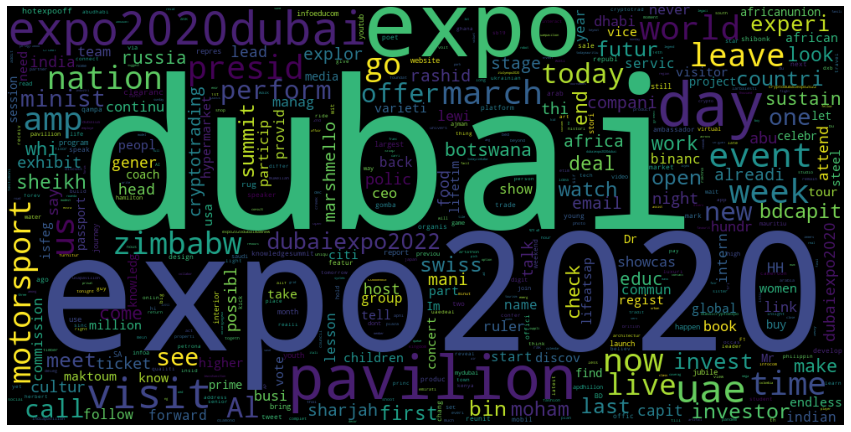

In [48]:
# Plotting the word cloud of negative words using the list of labled neutral
plt.figure(figsize = (15,15))
wcneu = WordCloud(max_words = 500 , width = 1000 , height = 500,
               collocations=False).generate(" ".join(neuctw))
plt.imshow(wcneu)
plt.axis('off')

# **Word** **Cloud** **For** **Positive** **Tweets**

(-0.5, 999.5, 499.5, -0.5)

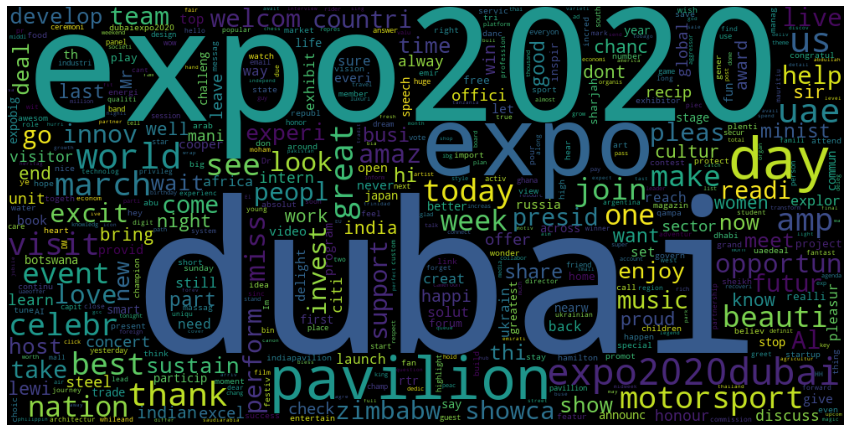

In [49]:
# Plotting the word cloud of negative words using the list of labled positive
plt.figure(figsize = (15,15))
wcpos = WordCloud(max_words = 500 , width = 1000 , height = 500,
               collocations=False).generate(" ".join(posctw))
plt.imshow(wcpos)
plt.axis('off')

This is a WordCloud Visualisation of the words based on the analysis of Positive, Neutral, and Negative of the pre-processed text. From the word cloud we can see what each of the tweets that were extracted contain the words that can distinguish between the analysis.

From the given WordCloud some of the word examples based on the analysis are as follows: -
* Positive: - Beauti, Thank, Good, Happi, Best, Great etc.
* Neutral: - Dubai, Sustain, Day, Perform, etc.
* Negative: -  Stop, Kill, Never. Shame, etc.



# **BarChart** **Of** **Tweets** **with** **its** **labled** **sentiment**

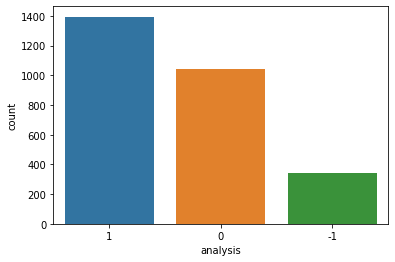

In [50]:
# Bar chart of analysis of the tweets based on the sentiments
sns.countplot(data=df3, x='analysis',order=df3['analysis'].value_counts().index)

The following bar chart represents that the majority of the tweets are labled positive with about 1400 tweets and the least are the negative tweets of about 300.

In [51]:
tokens = [word for sent in df3['tweets'] for word in sent.split()]
freqw = Counter(tokens)
freqws = sorted(freqw.items(), key=lambda pair: pair[1], reverse=True)
freqdf = pd.DataFrame(freqws[:20], columns=['word', 'counts'])
freqdf.head(10)

,word,counts
0,dubai,492
1,expo2020,469
2,expo,311
3,’,298
4,the,230
5,day,225
6,2020,224
7,pavilion,218
8,I,179
9,expo2020dubai,170


# **N-gram Analysis**

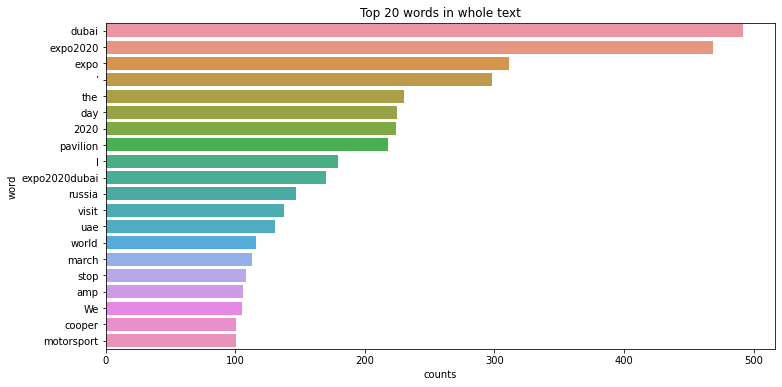

In [52]:
plt.figure(figsize=(12, 6))
sns.barplot(data=freqdf, x='counts', y='word')
plt.title('Top 20 words in whole text')
plt.show()

In [53]:
# Function to get the fequency of the words in the tweets of the specified sentiment
def freqswords(text, sentiment, num):

  tokens = [word for sent in text[text['analysis'] == sentiment]
            ['tweets'] for word in sent.split()]
  freqw = Counter(tokens)
  freqws = sorted(freqw.items(), key=lambda pair: pair[1], reverse=True)
  freqdf = pd.DataFrame(freqws[:num], columns=['word', 'counts'])
  return freqdf

# Function to plot the fequency of the words in the tweets of the specified sentiment
def plotfreq(data, st):
  plt.figure(figsize=(12, 6))
  sns.barplot(data=data, x='counts', y='word')
  plt.title(f'Top 20 words in {st} sentiment')
  plt.show()

**Unigram Barplot for Positive, Negative and Neutral Words**

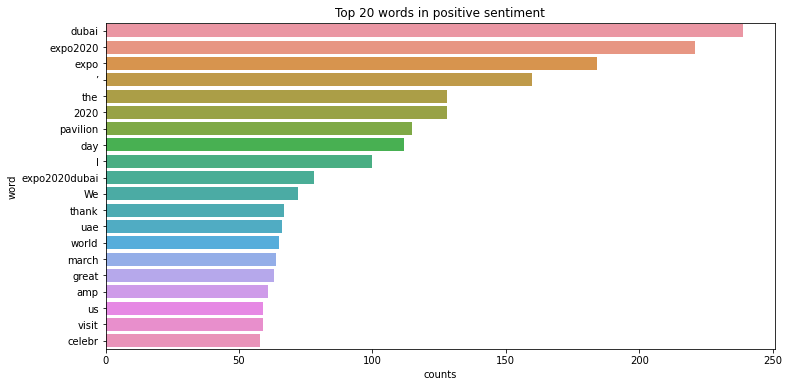

In [54]:
poswords = freqswords(df3, 1, 20)
plotfreq(poswords, "positive")

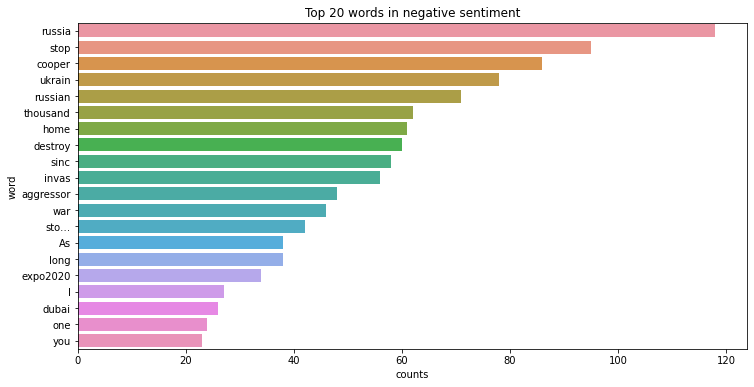

In [55]:
poswords = freqswords(df3, -1, 20)
plotfreq(poswords, "negative")

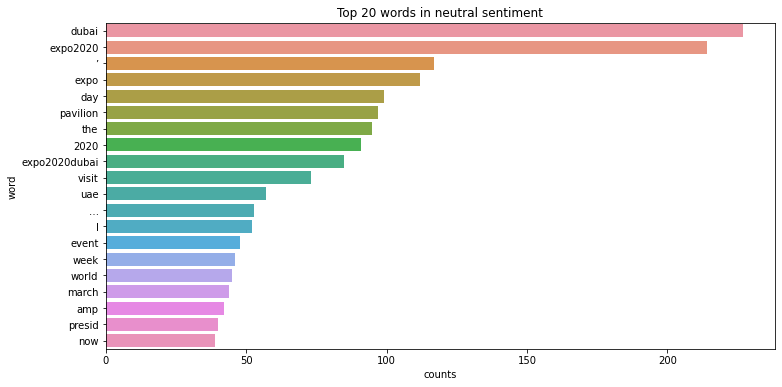

In [56]:
poswords = freqswords(df3, 0, 20)
plotfreq(poswords, "neutral")

In [57]:
# Function to get the fequency of the words in the tweets of the specified sentiment with the number of grams of words 
def getgram(corpus, analysis,  ngram, top_n=None):

  tokens = [word for sent in corpus[corpus['analysis'] ==analysis]['tweets'] for word in sent.split()]    

  grams = ngrams(tokens, ngram)
  grams = (' '.join(g) for g in grams)
  n_grams = [words for words in grams]
  freqw = Counter(n_grams)
  freqws = sorted(freqw.items(), key=lambda pair: pair[1], reverse=True)
  freqdf = pd.DataFrame(freqws[:top_n], columns=['word', 'counts'])
  return freqdf[:top_n]

**Bigram Barplot for Positive, Negative and Neutral Words**

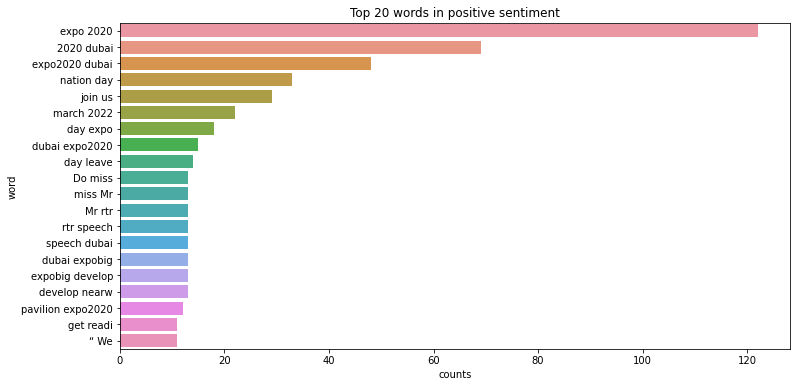

In [58]:
posgram = getgram(df3, 1, 2, 20)
plotfreq(posgram, 'positive')

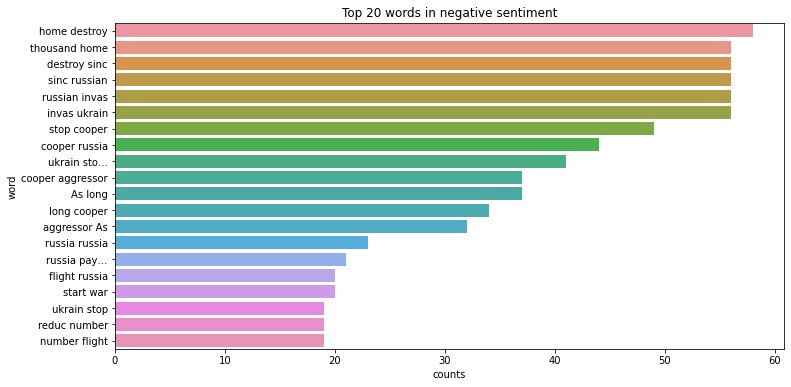

In [59]:
posgram = getgram(df3, -1, 2, 20)
plotfreq(posgram, 'negative')

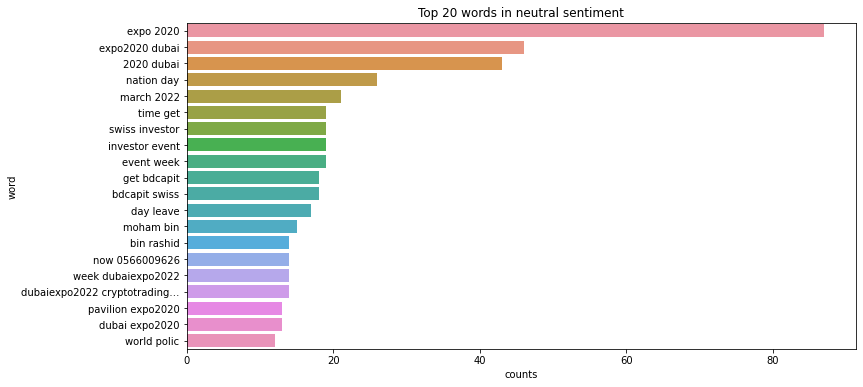

In [60]:
posgram = getgram(df3, 0, 2, 20)
plotfreq(posgram, 'neutral')

In this section frequency analysis of the top 20 words of each of the sentiment of differnt n-grams are produced.

The highest word count for Unigram Positive tweets was: - Dubai

The highest word count for Unigram Negative tweets was: - Russia

The highest word count for Unigram Neutral tweets was: - Dubai

The highest word count for Bigram Positive tweets was: - Expo 2020

The highest word count for Bigram Negative tweets was: - home destroy

The highest word count for Bigram Neutral tweets was: - Expo 2020

# **PyLDAVis** **Topic** **Modeling** **Visualisation**

In [61]:
# Vectorizing the tweets with Count Vectorizer for the LDA model
vectorizer_ = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True)
tweets_vectorized = vectorizer_.fit_transform(df3['tweets'])

In [ ]:
# LDA Model for the dataset
lda = LatentDirichletAllocation(n_components=3, max_iter=20, learning_method='online',verbose=True)
tweets_lda = lda.fit_transform(tweets_vectorized)

In [66]:
pyLDAvis.enable_notebook()
UI = pyLDAvis.sklearn.prepare(lda, tweets_vectorized, vectorizer_, mds='tsne')
UI

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  43.696818
1      -387.996002  -373.316162       2        1  29.986304
2     -2184.745605   -60.565800       3        1  26.316878, topic_info=           Term        Freq       Total Category  logprob  loglift
277    expo2020  450.000000  450.000000  Default  30.0000  30.0000
276        expo  291.000000  291.000000  Default  29.0000  29.0000
654      russia  169.000000  169.000000  Default  28.0000  28.0000
781         uae  144.000000  144.000000  Default  27.0000  27.0000
18         2020  205.000000  205.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
493      minist   33.122973   43.944194   Topic3  -4.8125   1.0523
231       dubai  109.496589  470.398319   Topic3  -3.6168  -0.1227
813        wait   28.355316   43.208393   Topic3  -4.9679   0.9137
507  motorsport   33.619579  104.190506   Topic3  -4.7976   0.2038
593      presid   28.270040   67.652334   Topic3  -4.9709   0.4624

[157 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         3  0.991606       10
8         3  0.964653       13
17        3  0.960297       20
18        1  0.994237     2020
20        3  0.986535     2022
...     ...       ...      ...
834       3  0.983076    women
837       2  0.980539     work
839       1  0.507895    world
839       2  0.490678    world
851       1  0.990502  zimbabw

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

We created a LDA Model using the Count Vectorized tweets which is then used for topic modeling and visualized using PyLDSVis. The words from the tweets were broken into 3 topics components and gave the resulting analysis: -

**Topic** **1**

This topic's most top relevent terms are expo2020, dubai, expo, day, pavilion, visit, etc. With the words being displayed in this topic, the words that are possibly neutral are being placed into topic 1.

**Topic** **2**

This topic's most top relevent terms are russia, stop, ukrain, destroy, war, etc. With the words being displayed in this topic, the words that are possibly negative are being placed into topic 2.

**Topic** **3**

This topic's most top relevent terms are dubai, march, team, best, enjoy, etc.With the words being displayed in this topic, the words that are possibly Positive are being placed into topic 3.



# **Discussion** **and** **conclusion** **from** **experiments**

In the first section of the sentiment analysis, we extracted the tweets relevant to Expo2020 using the tweepy API provided by twitter. After the tweets were successfully retrieved, they were then converted into a dataset and cleaned the text by removing tags, hash, punctuations, duplicates, etc. 

Moving foward, an initial analysis of the given tweets dataset was done using text blob. To lable the data we then used the VADER analysis in which we computed the compound score (polarity) and then labled the tweets in the dataset accordingly. 

Further ahead, the tweets in the dataset was pre-processed by tokenizing, stemming, lemmatizing the tweets using the nltk library. The resulting dataset was then vectorized using the td-idf vectorizer for the tweets, this was then used to split into train and test set which is used to train our classification models. After experimenting and training the model with 3 classification models (i.e Logistic Regression, Naive Bayes and Support Vector Machine) with different n-grams, the resulting observasions showed that SVM gave out a better precision and recall scores for the sentiment analysis of the given dataset and as the number of grams increases the scores of the classification models decreases slightly.

Finally, we did some visualisations of the dataset using word clouds, pie chats, frequency bar charts and topic modeling to get an basic insight and analysis of the dataset. From the given outputs we can analyse that people are enjoying and mostly positive about the expo 2020 event and only a few percent of the people feel unsatisfied by the event. Most of the negative tweets were related to the russian-ukrain war which resulted in showing russia and ukrain as part of the negative words. Using sentiment analysis for events can be useful as this can give an overview to the organisation about how their visitors feel about their event and how they could possibly improve based on the insights they get from the negative feedbacks. 

(Hasanli, Huseyn & Rustamov, Samir. (2019). Sentiment Analysis of Azerbaijani twits Using Logistic Regression, Naive Bayes and SVM. 1-7. 10.1109/AICT47866.2019.8981793.)  This was a study done on Twitter sentiment analysis tweets in Azerbaijani language. The machine learning methods they experimented with were Logistic Regression, SVM, and naive bayes classifires. This was also done using bag-of-words and td-if feature. The td-if Vectorizer method gave the SVM classification a higher accuracy scores than that of the other classifires.